# FashionMNIST CNN Classification

## import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
import torch
import torch.optim as optim

## parameters

In [2]:
batch_size = 24
learning_rate = 0.001
epochs = 100
momentum= 0.9

optimizer = optim.SGD
criterion = nn.CrossEntropyLoss

## load dataset

In [3]:
# transform to read data as tensor
transform = transforms.ToTensor()

#  torchvision datasets are PILImage images of range [0, 1].
train_data = FashionMNIST(root= "./data", train= True, download= True, transform= transform)
test_data = FashionMNIST(root= "./data", train= False, download= True, transform= transform)

train_loader = DataLoader(train_data, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(test_data, batch_size= batch_size, shuffle= True)

print("train data size:",len(train_data))
print("test data size:",len(test_data))

print("train loader size:",len(train_loader))
print("train loader size:",len(test_loader))


# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.85MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.96MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

train data size: 60000
test data size: 10000
train loader size: 2500
train loader size: 417


Image Shape:  (24, 1, 28, 28)
Label:  [0 4 3 7 6 5 1 4 3 5 4 1 9 7 8 3 9 7 3 0 6 1 7 8]


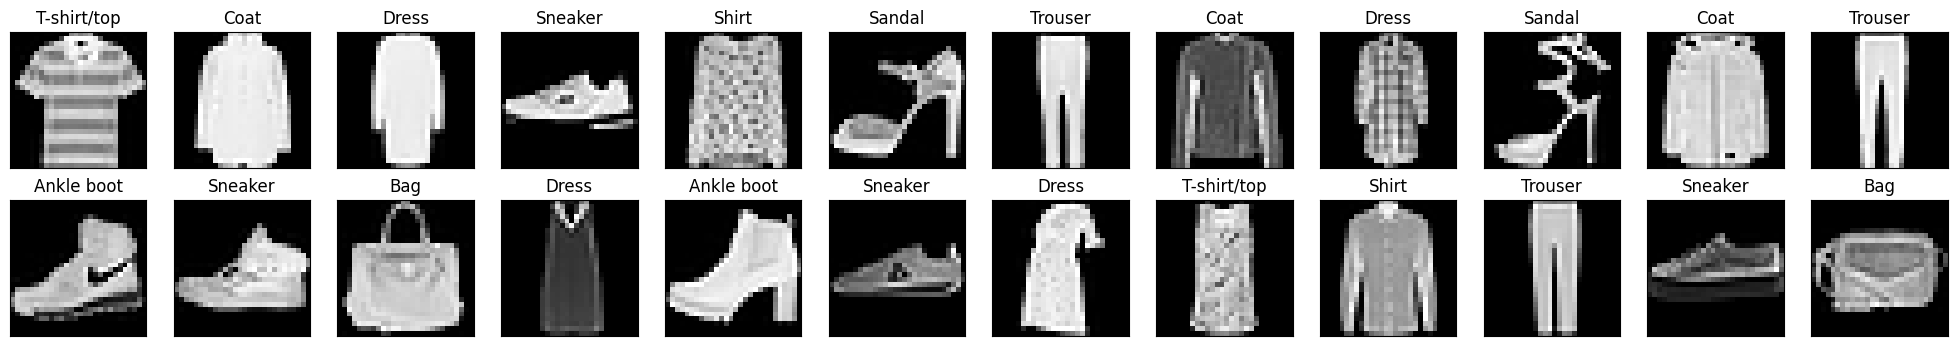

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter._next_data()
images = images.numpy()
print('Image Shape: ', images.shape)
print('Label: ', labels.numpy())
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

# cnn architecture

In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    # (w-f+2p)/s+1
    # (28-3 + (2*0))/1 +1 = 26
    # out_put = (32, 26, 26)

    self.relu1 = F.relu

    # kernel 2 , stride 2
    self.pool1 = nn.MaxPool2d(2,2)
    # out_put = (32, 13, 13)

    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    # output shape = (64, 11, 11)

    self.relu2 = F.relu

    self.pool2 = nn.MaxPool2d(2,2)
    # output shape = (64, 5, 5)

    # 64 output with 5*5 filtered/pool mapsize
    # 10 output channel
    self.fc1 = nn.Linear(64*5*5, 50)
    self.relu3= F.relu
     # dropout with p=0.4
    self.fc1_drop = nn.Dropout(p=0.4)
    # finally, create 10 output channels (for the 10 classes)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    # Flatten
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc1_drop(x)
    x = self.fc2(x)
    return x


In [6]:
model = Net()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         MaxPool2d-2           [-1, 32, 13, 13]               0
            Conv2d-3           [-1, 64, 11, 11]          18,496
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Linear-5                   [-1, 50]          80,050
           Dropout-6                   [-1, 50]               0
            Linear-7                   [-1, 10]             510
Total params: 99,376
Trainable params: 99,376
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.38
Estimated Total Size (MB): 0.66
----------------------------------------------------------------


# get trained model

In [7]:
! unzip saved_models.zip
# instantiate your Net
model = Net()

# load the net parameters by name
model.load_state_dict(torch.load('saved_models/fashion_net_ex.pt'))

print(model)

Archive:  saved_models.zip
   creating: saved_models/
  inflating: saved_models/fashion_net_ex.pt  
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


<ipython-input-7-6e44a782a7a4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_models/fashion_net_ex.pt'))


## feature Visualization

In [13]:
# get weights
weight1 = model.conv1.weight.data.numpy()
print(weight1.shape)

weight2 = model.conv2.weight.data.numpy()
print(weight2.shape)

(32, 1, 3, 3)
(64, 32, 3, 3)


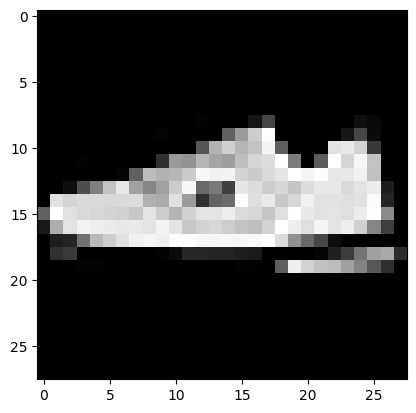

In [20]:
plt.imshow(np.squeeze(images[3]),cmap= "gray")

In [31]:
import cv2
def plot_filte(weight, image):
  fig = plt.figure(figsize=(30, 10))
  plt.axis('off')
  # for 10 filters
  col = 2 * 5
  row = 5

  for i in range(0,row * col):
    fig.add_subplot(row, col, i+1)
    # plot first 10
    if ( (i% 2) == 0):
      plt.imshow(weight[int(i/2)][0], cmap= "gray")
    else:
      plt.imshow(cv2.filter2D(image, -1, weight[int((i-1)/2)][0]), cmap= "gray")
  plt.show()



## first conv layer

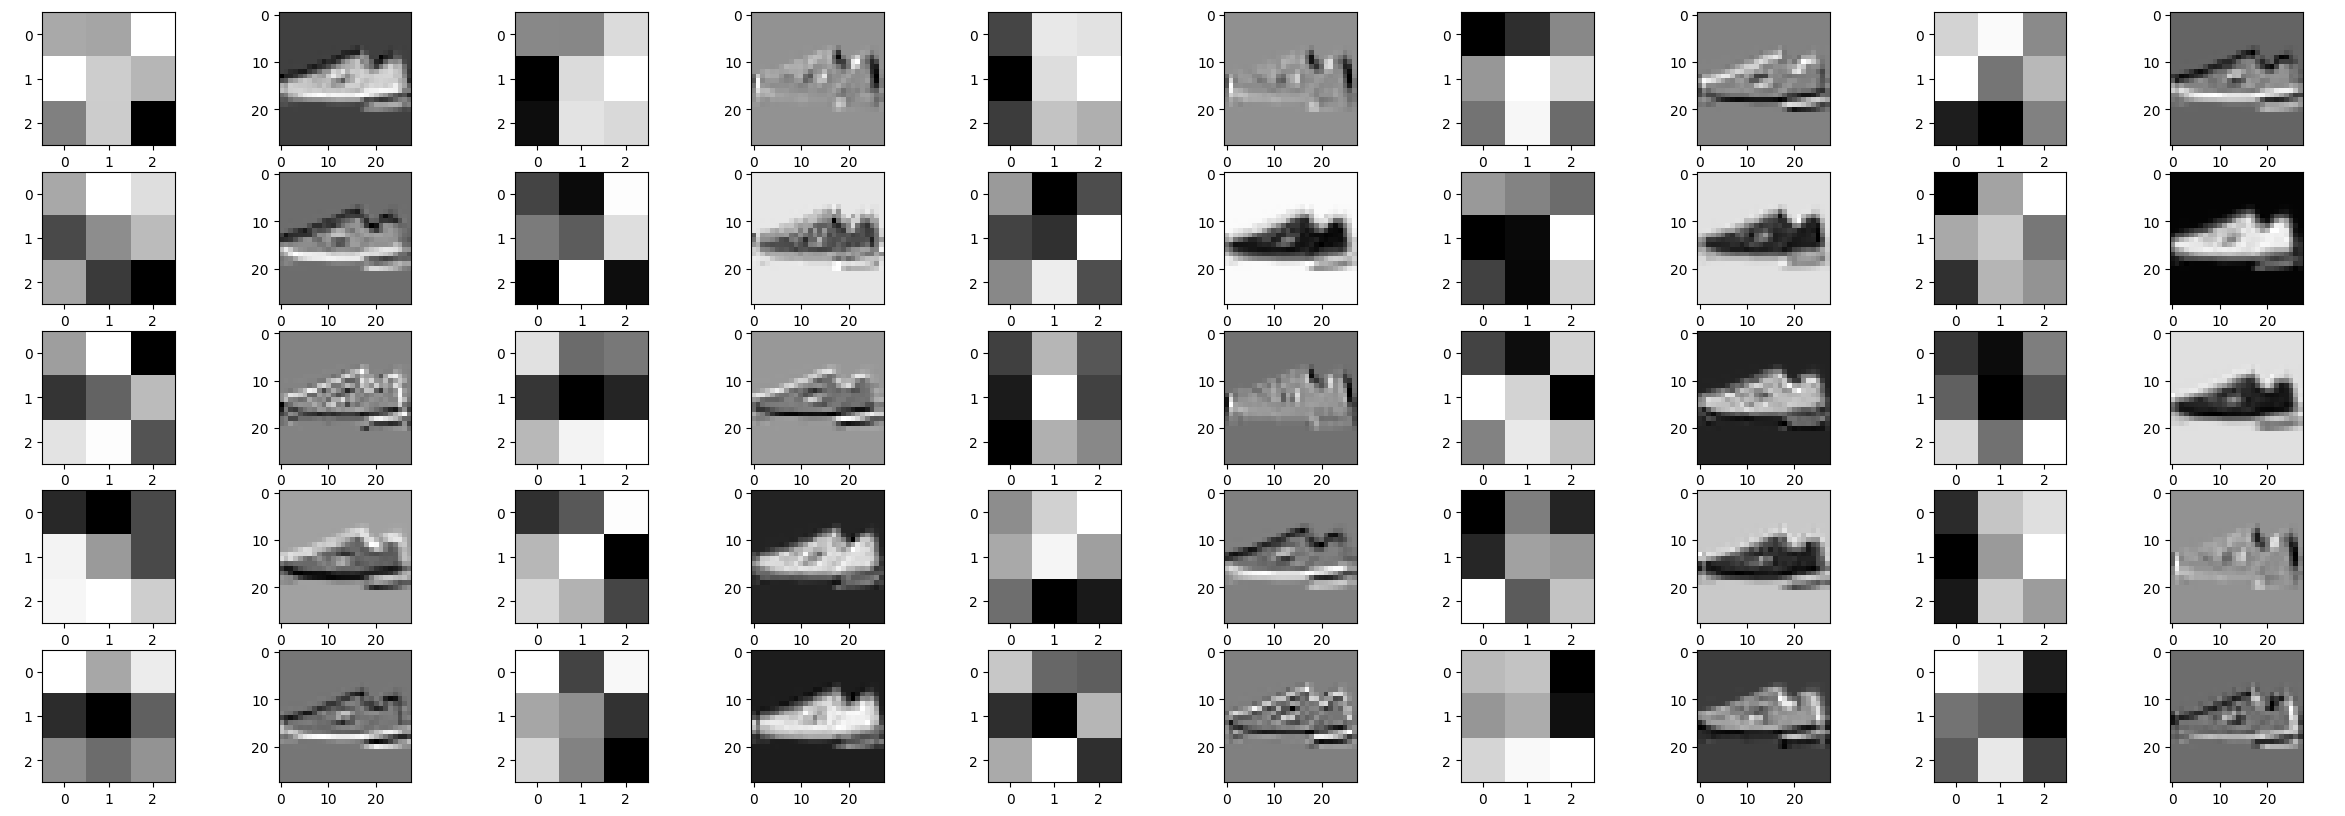

In [32]:
plot_filte(weight1, np.squeeze(images[3]))

## secound conv layer

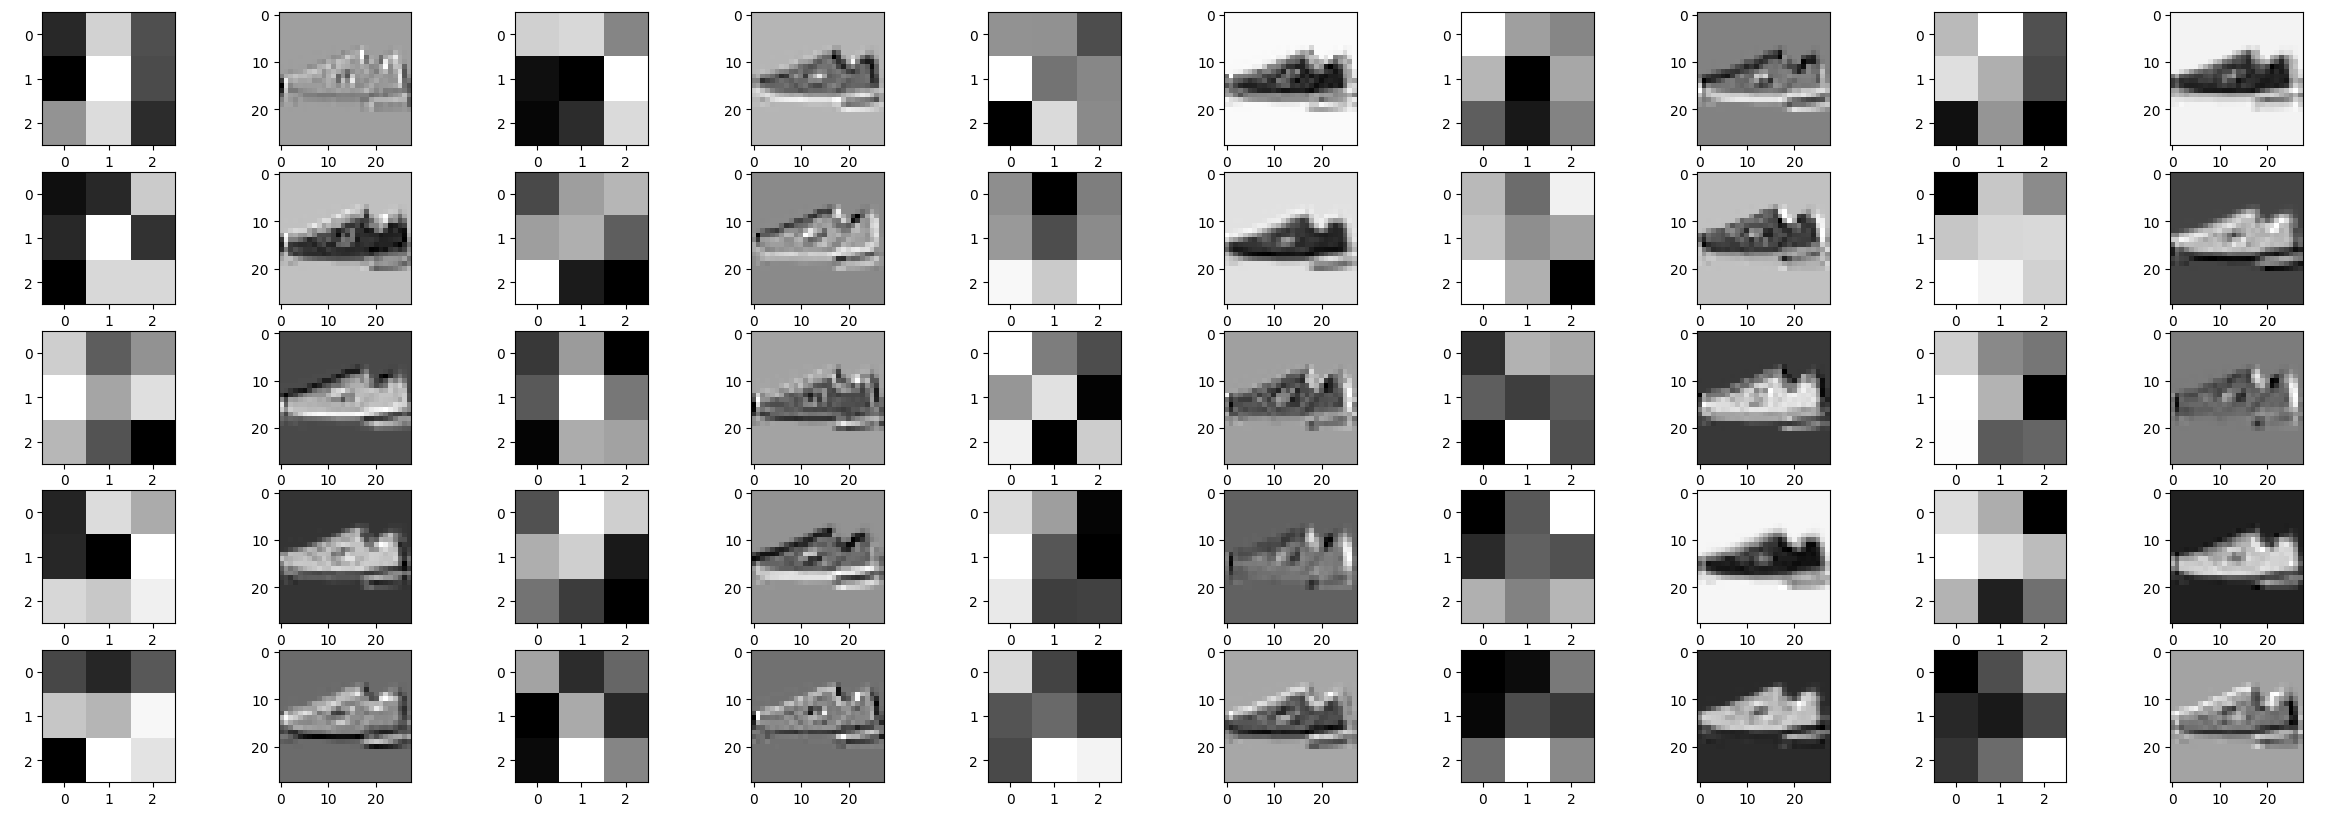

In [33]:
plot_filte(weight2, np.squeeze(images[3]))

## activation layer

In [39]:
def plot_filte_active(weight, image):
  fig = plt.figure(figsize=(30, 10))
  plt.axis('off')
  # for 10 filters
  col = 2 * 5
  row = 5

  for i in range(0,row * col):
    fig.add_subplot(row, col, i+1)
    # plot first 10
    if ( (i% 2) == 0):
      plt.imshow(weight[int(i/2)][0], cmap= "gray")
    else:
      fil = cv2.filter2D(image, -1, weight[int((i-1)/2)][0])
      fil = torch.tensor(fil)
      active = F.relu(fil)
      plt.imshow(active.numpy(),cmap= "gray")
  plt.show()

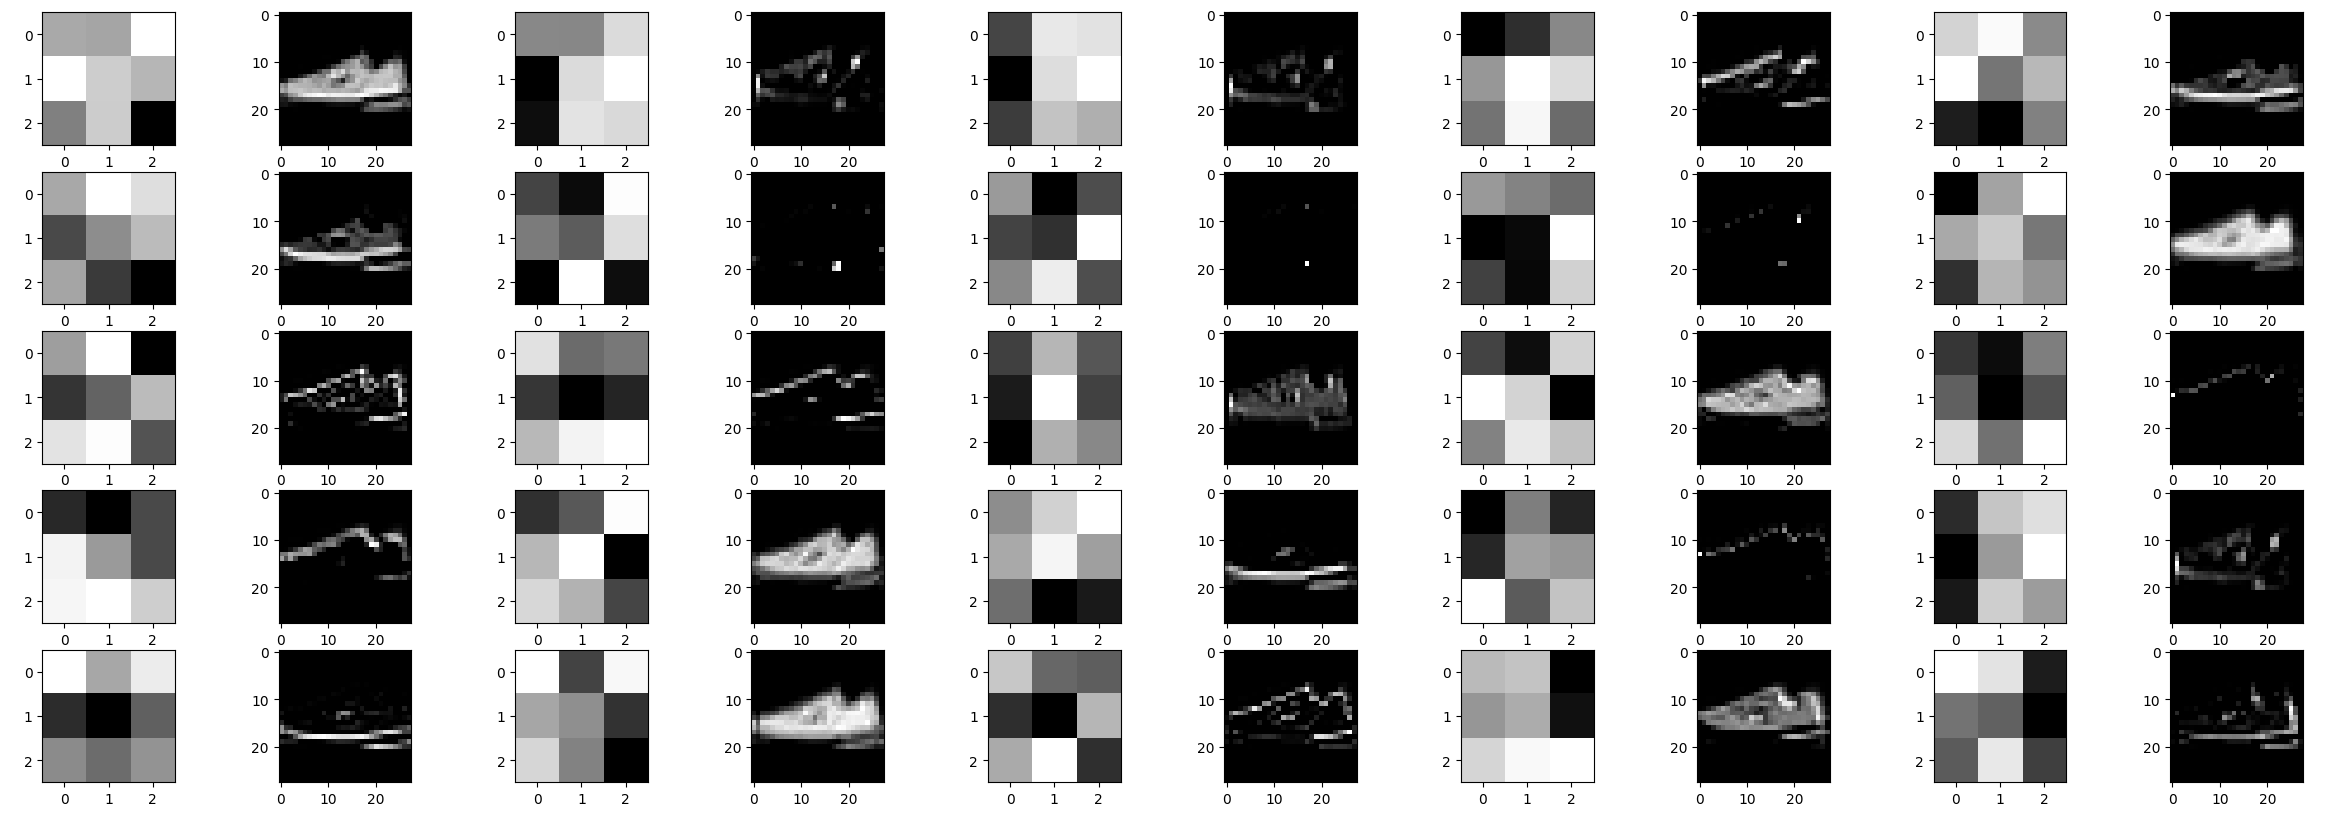

In [40]:
plot_filte_active(weight1, np.squeeze(images[3]))

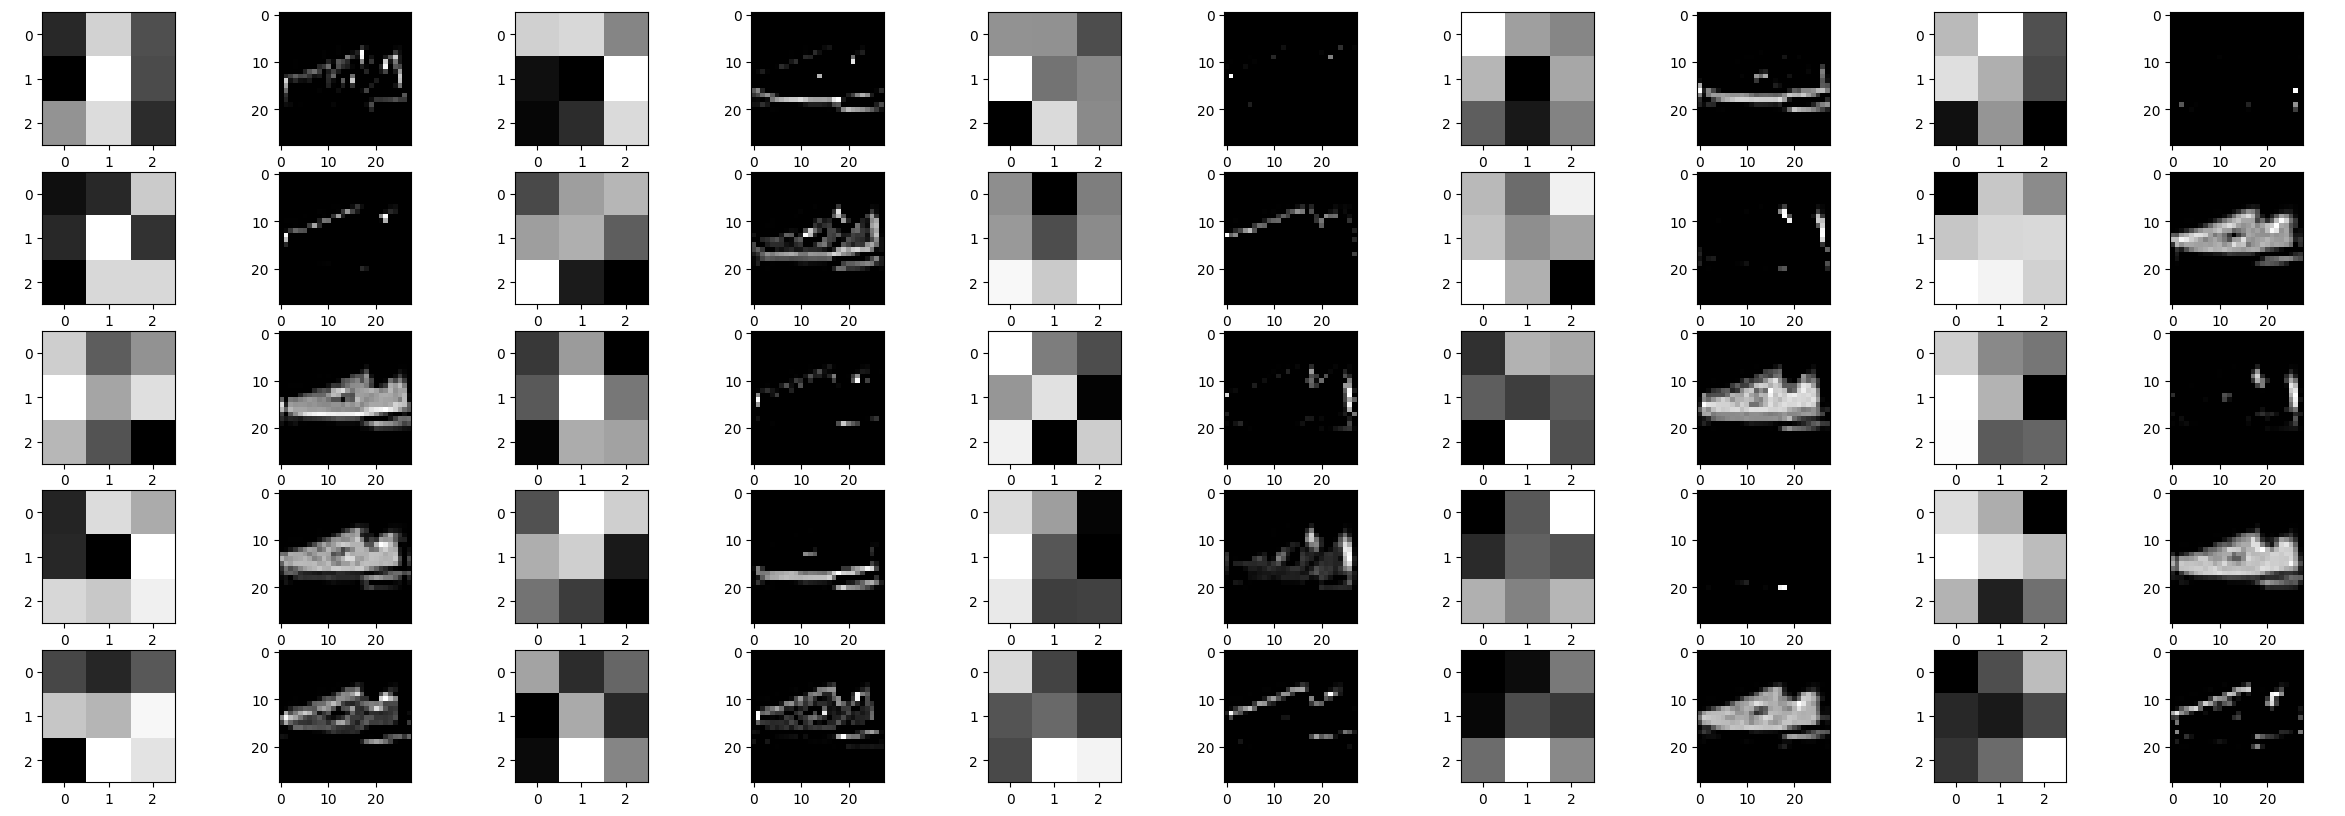

In [41]:
plot_filte_active(weight2, np.squeeze(images[3]))